In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

import torch.optim as optim
import torch
import torch.nn as nn

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display,clear_output

import warnings
warnings.filterwarnings("ignore")

In [3]:
from dataset import CompasDataset
from experiments import Benchmarking
from utils.logger_config import setup_logger
from tqdm import tqdm
from models.wrapper import PYTORCH_MODELS

logger = setup_logger()

In [4]:
from dataset import dataset_loader

In [5]:
name = 'compas'
dataset_ares = dataset_loader(name, data_path='data/', dropped_features=[], n_bins=None)

In [27]:
from experiments.counterfactual import *
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from models import PyTorchDNN, PyTorchLinearSVM, PyTorchRBFNet,PyTorchLogisticRegression,PyTorchLinearSVM
from sklearn.metrics import accuracy_score, classification_report
from sklearn.gaussian_process import GaussianProcessClassifier

dataset = CompasDataset(dataset_ares=dataset_ares)
input_dim = dataset.get_dataframe().shape[1] - 1
seed = 1
torch.manual_seed(seed)

counterfactual_algorithms = [
    # 'DiCE',
    # 'DisCount',
    # 'GlobeCE'
    'AReS',
]

experiment = Benchmarking(
    dataset=dataset,
    models=[
        # (GaussianProcessClassifier(),'sklearn'),
        # (PyTorchLogisticRegression(input_dim=input_dim), 'PYT'),
        # (PyTorchDNN(input_dim=input_dim), 'PYT'),
        # (PyTorchRBFNet(input_dim=input_dim, hidden_dim=input_dim), 'PYT'),
        (PyTorchLinearSVM(input_dim=input_dim), 'PYT'),
        # (RandomForestClassifier(n_estimators=10), 'sklearn'), 
        # (GradientBoostingClassifier(n_estimators=10), 'sklearn'), 
        # (AdaBoostClassifier(n_estimators=10), 'sklearn'), 
    ],
    shapley_methods=[
        # "Train_Distri",
        "CF_UniformMatch",
        # "CF_SingleMatch",
        # "CF_ExactMatch",
        "CF_SingleMatch",
        "CF_OTMatch",
        # "CF_OTMatch_0.5", 
        # "CF_OTMatch_1.0",
        "CF_OTMatch_5.0",
        # "CF_OTMatch_10.0",
    ],
    distance_metrics=[
        'optimal_transport',
        'mean_difference',
        # 'median_difference',
        # 'max_mean_discrepancy',
    ]
)

experiment.train_and_evaluate_models(random_state=seed)
experiment.models_performance()


logger.info("\n\n------Compute Counterfactuals------")
sample_num = 300
model_counterfactuals = {}
for model, model_name in zip(experiment.models, experiment.model_names):
    model_counterfactuals[model_name] = {}

    for algorithm in counterfactual_algorithms:
        if algorithm == 'DisCount' and model_name not in PYTORCH_MODELS:
            logger.info(f'Skipping {algorithm} for {model_name} due to incompatability')
            continue
        logger.info(f'Computing {model_name} counterfactuals with {algorithm}')
        function_name = f"compute_{algorithm}_counterfactuals"
        try:
            func = globals()[function_name]
            model_counterfactuals[model_name][algorithm] = func(
                experiment.X_test,
                model = model,
                target_name = experiment.dataset.target_name,
                sample_num = sample_num,
                experiment=experiment,
            )
        except KeyError:
            print(f"Function {function_name} is not defined.")




INFO:root:PyTorchLinearSVM accuracy: 0.6615384615384615
INFO:root:

------Compute Counterfactuals------
INFO:root:Computing PyTorchLinearSVM counterfactuals with AReS
C:\Users\leiyo\AppData\Roaming\Python\Python39\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Computing Candidate Sets of Conjunctions of Predicates SD and RL
Processing 12 combinations | Sampling itemset size 43
SD and RL Computed with Lengths 60 and 60
Computing Ground Set of Triples V
Reducing RL
RL Reduced from Size 60 to 50


100%|██████████| 60/60 [00:00<00:00, 2989.03it/s]


Ground Set Computed with Length 1090


199it [00:00, 564.39it/s]


Candidate Set Filtered with Length: 200
Initialising Copy of Ground Set
While there exists a delete/update operation, loop:
Checking Delete
Checking Add


100%|██████████| 199/199 [00:00<00:00, 13263.41it/s]


Checking Exchange


100%|██████████| 193/193 [00:00<00:00, 1723.36it/s]


Checking Delete
Checking Add


100%|██████████| 193/193 [00:00<00:00, 13693.66it/s]
6it [00:00, 411.66it/s]


In [28]:
logger.info("\n\n------Compute Shapley Values------")
experiment.compute_shapley_values(
    model_counterfactuals=model_counterfactuals,
);

INFO:root:

------Compute Shapley Values------
INFO:root:Shapley values for PyTorchLinearSVM using CF_UniformMatch with counterfactual by AReS


  0%|          | 0/53 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 3
INFO:shap:remaining_weight_vector = array([0.3626943 , 0.32642487, 0.31088083])
INFO:shap:num_paired_subset_sizes = 6
INFO:shap:weight_left = 0.32084025993652715
C:\Users\leiyo\AppData\Roaming\Python\Python39\site-packages\shap\explainers\_kernel.py:640: DeprecationWarning: l1_reg='auto' is deprecated and in a future version the behavior will change from a conditional use of AIC to simply a fixed number of top features. Pass l1_reg='num_features(10)' to opt-in to the new default behaviour.
  warnings.warn(
INFO:shap:phi = array([-0.00761341,  0.00221397,  0.10048175,  0.01975325, -0.0340834 ,
       -0.14298577,  0.1906903 , -0.03160572, -0.00541351,  0.04430971,
       -0.0544442 ,  0.08023982, -0.00196532])
INFO:shap:num_full_subsets = 3
INFO:shap:remaining_weight_vector = array([0.3626943 , 0.32642487, 0.31088083])
INFO:shap:num_paired_subset_sizes = 6
INFO:shap:weight_left = 0.32084025993652715
C:\Users\leiyo\AppData\Roaming\Python\Python39\site-packa

In [33]:
logger.info("\n\n------Evaluating Distance Performance Under Interventions------")
experiment.evaluate_distance_performance_under_interventions(
    intervention_num_list=[0, 10, 20, 30, 40, 50, 100, 200, 300, 400],
    trials_num=100,
    replace=False
)


INFO:root:

------Evaluating Distance Performance Under Interventions------
INFO:root:Computing optimal_transport for (PyTorchLinearSVM, AReS, CF_UniformMatch)
100%|██████████| 100/100 [00:00<00:00, 128.32it/s]
INFO:root:Computing mean_difference for (PyTorchLinearSVM, AReS, CF_UniformMatch)
100%|██████████| 100/100 [00:00<00:00, 335.20it/s]
INFO:root:Computing optimal_transport for (PyTorchLinearSVM, AReS, CF_SingleMatch)
100%|██████████| 100/100 [00:00<00:00, 127.91it/s]
INFO:root:Computing mean_difference for (PyTorchLinearSVM, AReS, CF_SingleMatch)
100%|██████████| 100/100 [00:00<00:00, 314.15it/s]
INFO:root:Computing optimal_transport for (PyTorchLinearSVM, AReS, CF_OTMatch)
100%|██████████| 100/100 [00:00<00:00, 130.23it/s]
INFO:root:Computing mean_difference for (PyTorchLinearSVM, AReS, CF_OTMatch)
100%|██████████| 100/100 [00:00<00:00, 297.54it/s]
INFO:root:Computing optimal_transport for (PyTorchLinearSVM, AReS, CF_OTMatch_5.0)
100%|██████████| 100/100 [00:00<00:00, 142.64it/s

In [34]:
# from copy import deepcopy
# distance_results_backup = deepcopy(experiment.distance_results)

In [35]:
# import pickle

# # Update from existing file
# with open(f"pickles/{dataset.name}_distance_results.pickle", "rb") as input_file:
#     experiment.distance_results.update(pickle.load(input_file))

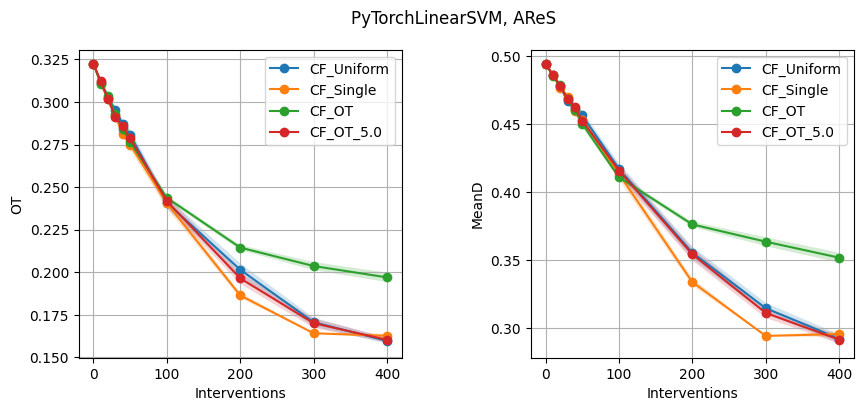

In [36]:
from experiments import plotting

plotting.intervention_vs_distance(experiment, save_to_file=False)

In [ ]:
# import pickle
# # Dump results
# with open(f"pickles/{dataset.name}_distance_results.pickle", "wb") as output_file:
#     pickle.dump(experiment.distance_results, output_file)

In [14]:
X_test = experiment.X_test
target_name = dataset.target_name
sample_num = 300

In [17]:
indices = get_factual_indices(X_test, model, target_name, sample_num)
df_factual = X_test.loc[indices]

ares = AReS(
    model=model,
    dataset=experiment.dataset.dataset_ares,
    X=df_factual,
    n_bins=10,
    normalise=None,
)  # 1MB


In [ ]:
ares.generate_itemsets(
    apriori_threshold=0.2,
    max_width=None,  # defaults to e2-1
    affected_subgroup=None,
    save_copy=False,
)

# Note: progress bar initial time estimate about 10 times too large
ares.generate_groundset(
    max_width=None, RL_reduction=True, then_generation=None, save_copy=False
)
lams = [1, 0]  # can play around with these lambda values
ares.evaluate_groundset(
    lams=lams, r=5000, save_mode=1, disable_tqdm=False, plot_accuracy=False
)
ares.select_groundset(s=5000)
ares.optimise_groundset(lams=lams, factor=1, print_updates=False, print_terms=False)

df_counterfactual = pd.DataFrame(ares.R.cfx_matrix[0], columns=X_test.columns)